### Задача:

На основе аналитических данных сети фитнес-центров «Культурист-датасаентист» провести анализ и подготовить план действий по удержанию клиентов.

### Шаг 1. Загрузите данные
«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные пользователя за предыдущий до проверки факта оттока месяц:

'gender' — пол

'Near_Location' — проживание или работа в районе, где находится фитнес-центр

'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)

Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)

'Phone' — наличие контактного телефона

'Age' — возраст

'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента

'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)

'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)

'Group_visits' — факт посещения групповых занятий

'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента

'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц

'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

%config InlineBackend.figure_format='svg'

pd.options.display.max_columns = None
pd.option_context.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
try:
    df = pd.read_csv(r'C:\Users\Иванов\gym_churn.csv')    
except FileNotFoundError as e:
    print(repr(e))
    df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
display(df.head())
df.info()
print(f"Количество дубликатов в датафрейме: {df.duplicated().sum()}")

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

### Шаг 2. Проведите исследовательский анализ данных (EDA)
Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());
Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());
Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
Постройте матрицу корреляций и отобразите её.

In [4]:
df.describe()

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [5]:
display(df.groupby('Churn').agg(['mean']).reset_index().T)

0           1
Churn                                     0.000000    1.000000
gender                            mean    0.510037    0.510839
Near_Location                     mean    0.873086    0.768143
Partner                           mean    0.534195    0.355325
Promo_friends                     mean    0.353522    0.183789
Phone                             mean    0.903709    0.902922
Contract_period                   mean    5.747193    1.728558
Group_visits                      mean    0.464103    0.268615
Age                               mean   29.976523   26.989632
Avg_additional_charges_total      mean  158.445715  115.082899
Month_to_end_contract             mean    5.283089    1.662582
Lifetime                          mean    4.711807    0.990575
Avg_class_frequency_total         mean    2.024876    1.474995
Avg_class_frequency_current_month mean    2.027882    1.044546

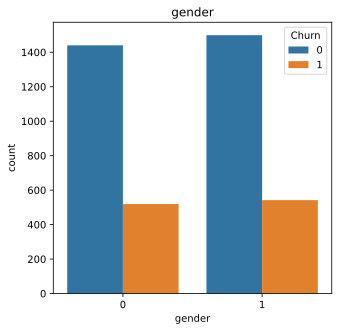

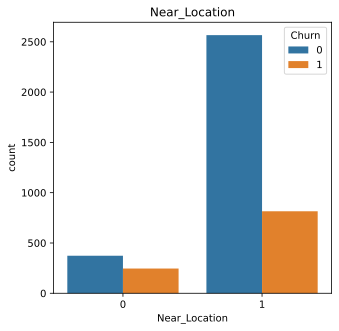

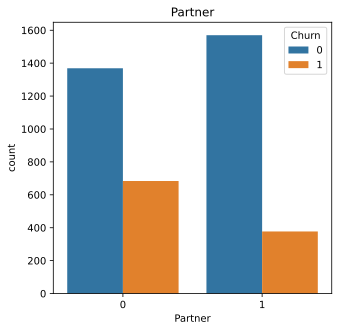

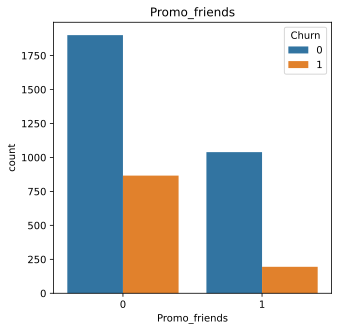

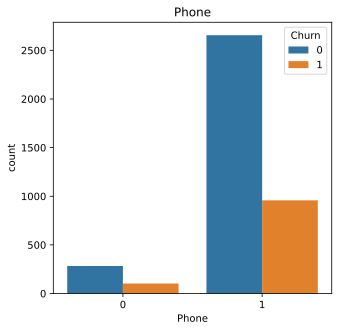

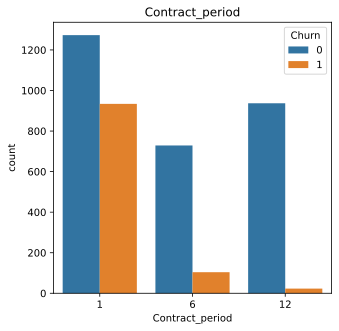

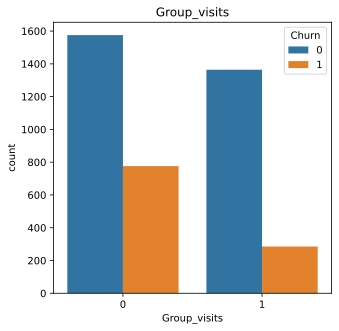

In [6]:
for column in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(data=df, x=column, hue='Churn')
    plt.title(column)
    plt.show()

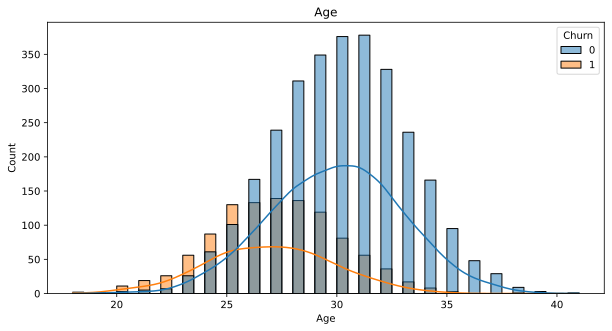

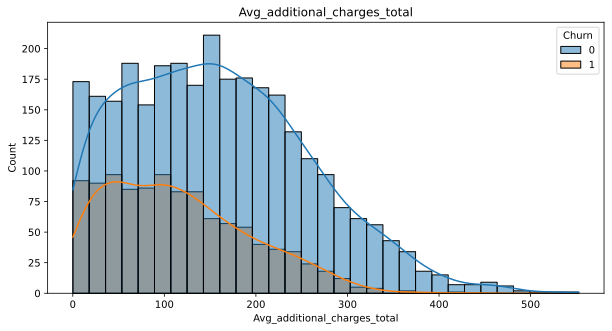

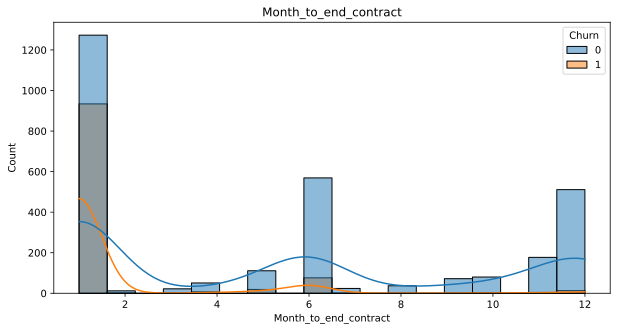

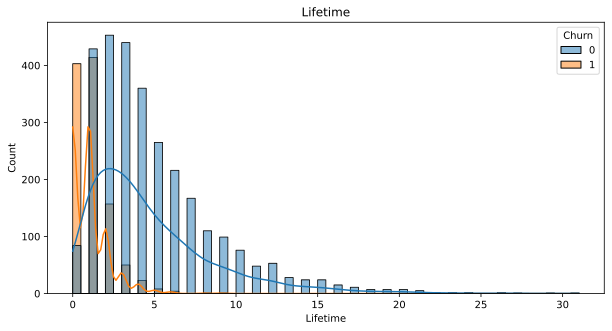

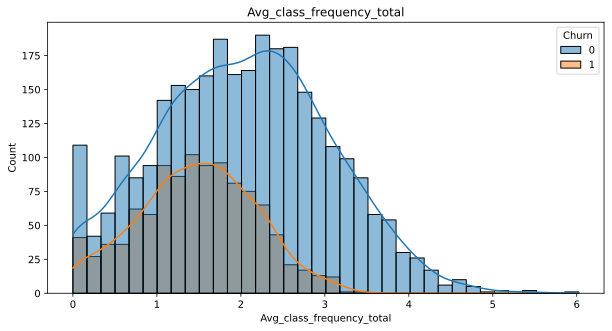

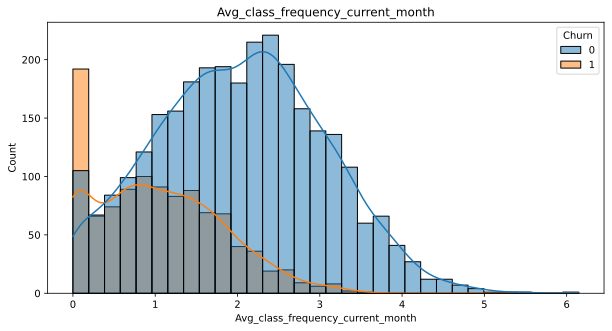

In [7]:
for column in ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=column, hue='Churn', kde=True)
    plt.title(column)
    plt.show()

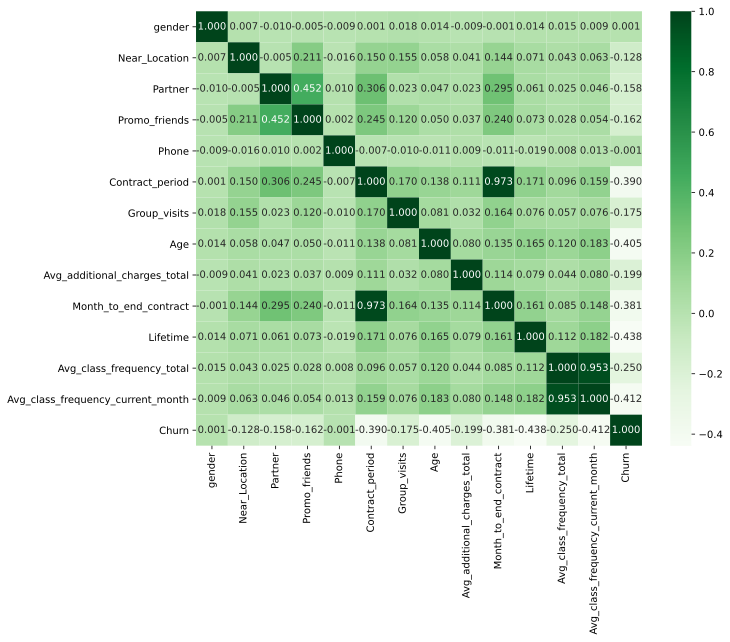

In [8]:
cm = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = '0.3f', cmap="Greens")
plt.show()

Меньше всего уходят в отток:

* клиенты живущие или работающие в районе фитнес-центра
* сотрудники компании-партнёра клуба
* клиенты с длительным абонементом
* использовавшие промо-код от знакомого при оплате первого абонемента
* посещявшие групповые занятия
* более возрастная категория

Мультиколлинеарные признаки:
1. 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)

2. 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### Шаг 3. Постройте модель прогнозирования оттока пользователей
Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
Обучите модель на train-выборке двумя способами:
логистической регрессией
случайным лесом
Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?
Не забудьте указать параметр random_state при разделении выборки и задании алгоритма.

In [9]:
X = df.drop('Churn', axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Логистическая регрессия

In [10]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.91
Precision: 0.83
Recall: 0.80
F1: 0.81


C:\anaconda3\envs\da_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Случайный лес

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


На регрессии ошибки меньше.

### Шаг 4. Сделайте кластеризацию пользователей
Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (пользователей):
Стандартизируйте данные.
Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [12]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(df.drop(columns = ['Churn'], axis=1))

In [13]:
linked = linkage(x_sc, method = 'ward')

In [14]:
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation = 'top')
plt.title('кластеризация пользователей')
plt.show()

Предложенное оптимальное число кластеров 4, но исходя из задания принимаем равным 5. 

In [15]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)

In [16]:
df['cluster'] = labels
df['cluster'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

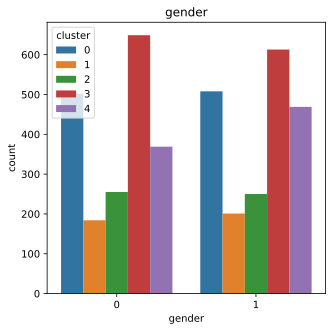

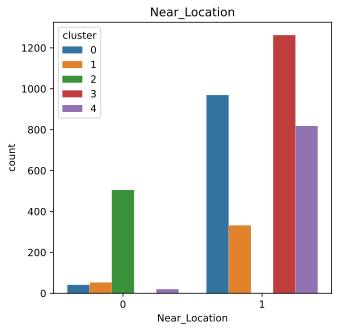

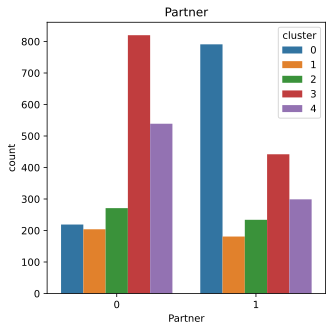

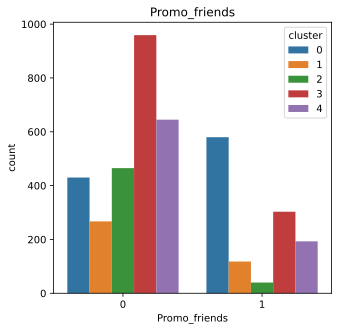

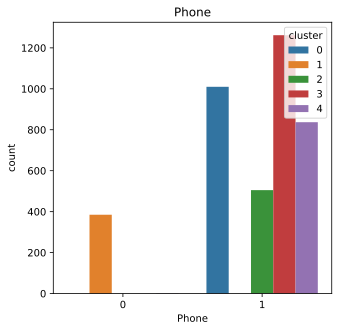

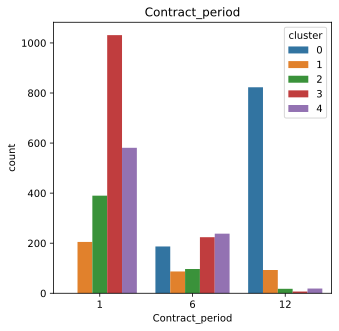

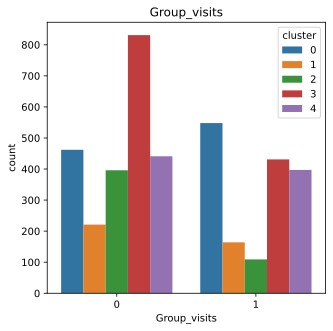

In [17]:
for column in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(data=df, x=column, hue='cluster')
    plt.title(column)
    plt.show()

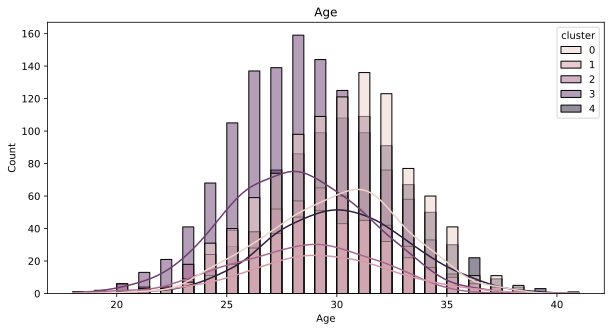

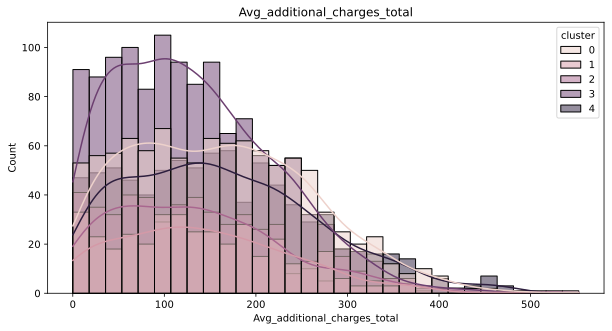

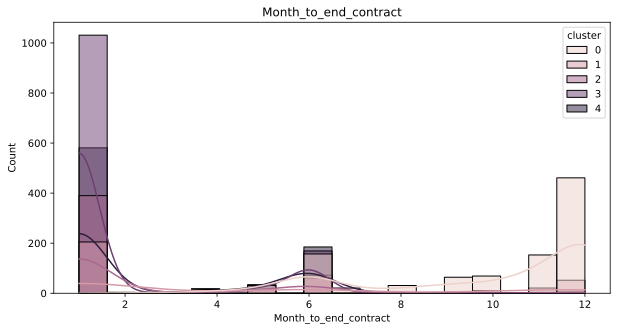

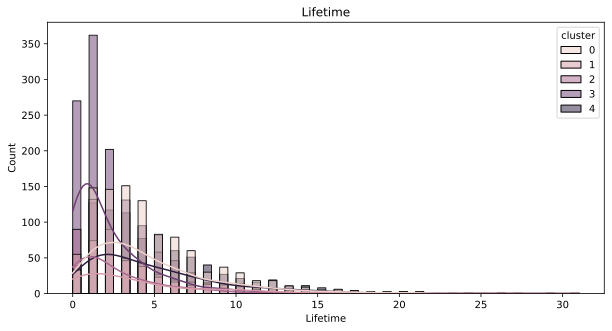

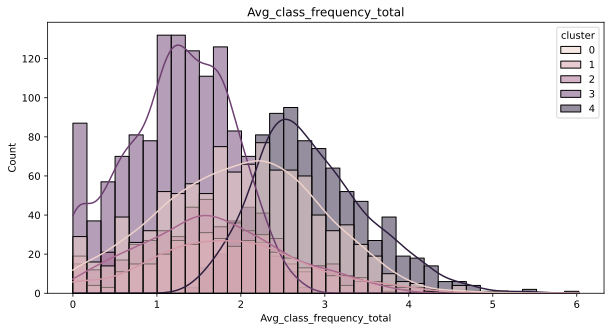

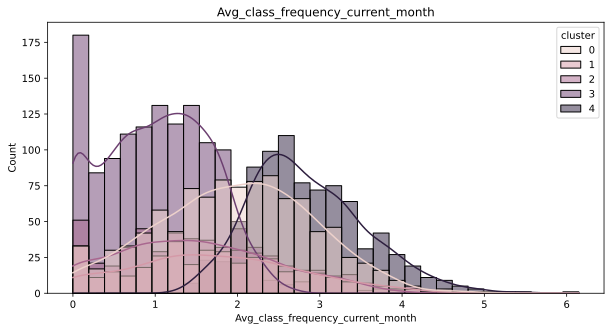

In [18]:
for column in ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=column, hue='cluster', kde=True)
    plt.title(column)
    plt.show()

In [19]:
df.groupby('cluster').mean().T

cluster                                     0           1           2  \
gender                               0.502970    0.522078    0.495050   
Near_Location                        0.959406    0.862338    0.000000   
Partner                              0.783168    0.470130    0.463366   
Promo_friends                        0.574257    0.306494    0.079208   
Phone                                1.000000    0.000000    1.000000   
Contract_period                     10.889109    4.787013    2.352475   
Group_visits                         0.542574    0.425974    0.215842   
Age                                 29.982178   29.301299   28.477228   
Avg_additional_charges_total       160.761016  143.957664  135.457501   
Month_to_end_contract                9.954455    4.475325    2.198020   
Lifetime                             4.736634    3.924675    2.809901   
Avg_class_frequency_total            1.982055    1.847220    1.660461   
Avg_class_frequency_current_month    1.974789    1.716369    1.477324   
Churn                                0.027723    0.267532    0.443564   

cluster                                     3           4  
gender                               0.485737    0.559666  
Near_Location                        1.000000    0.976134  
Partner                              0.350238    0.356802  
Promo_friends                        0.240095    0.230310  
Phone                                1.000000    0.998807  
Contract_period                      1.948494    2.669451  
Group_visits                         0.341521    0.473747  
Age                                 28.167987   30.125298  
Avg_additional_charges_total       131.622204  161.657905  
Month_to_end_contract                1.856577    2.459427  
Lifetime                             2.440571    4.898568  
Avg_class_frequency_total            1.247634    2.852002  
Avg_class_frequency_current_month    1.012983    2.850161  
Churn                                0.514263    0.068019

Кластеры не равномерны по количеству клиентов. Доля оттока тоже разная.

Самые большие оттоки у 3 и 2 кластера. Минимум у 0.

Клиенты живущие или работающие в районе фитнес-центра определены в 3 кластер, клиенты не с района во второй.

Клиенты с наличием контактного телефона в 1.

Самые возрастные клиенты в основном в 0 кластере, молодые - в 4.

По длительности текущего действующего абонемента в 0 кластере больше "длительных" клиентов, в 3 меньше.

### Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами
Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с пользователями и их удержания.
Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

"Хороший" кластер имеет следующие признаки:
* более возрастной
* более длительный абонемент
* в нем больше сотрудников компании-партнёра клуба
* более длительное время с момента первого обращения
* суммарная выручка от других услуг фитнес-центра больше
* средняя частота посещений больше


Рекомендации:
* ставку на рекламе сделать на привлечении пользователей из аудитории "хороших" кластеров.
* ввести дополнительные "бонусы" для мотивации "хороших" кластеров.
* искать дополнительных компаний-партнёров
* провести сегментацию пользователей и продумать для каждого сегмента индивидуальные предложения
